# Synthetic Data Experiment


In [1]:
# Load all necessary packages
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from utils import generate_data,  generate_a_hat, generate_y_hat
from balancers import BinaryBalancer
from tqdm import tqdm
sns.set_theme()

In [2]:
# Pick imbalanced or balanced errors of A_hat
imbalance = True
results_dir = 'results/balanced_errors/'
if imbalance == True:
    results_dir = 'results/imbalanced_errors/'

# Generate data
n = 10000
e0 = 2
e1 = 1.5
e0 = 1
e1 = 0.5
b = 0.05
t = 0.5
group = 0
X, a, y  = generate_data(n,e0,e1,b,t)
u = 0.02
a_hat = generate_a_hat(X[:,2], b, u, imbalance=imbalance)

# Generate y_hat using random coefficients
mu_c = np.array([1,1,1])
var_c = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.01]])

In [3]:
# Run experiment
K = 1000
num_rows = len(a)

d_tpr = []
d_fpr = []
d_tpr_fair = []
d_fpr_fair = []
d_tpr_opt = []
d_fpr_opt = []

b_tpr = []
b_fpr = []
th_b_tpr_fair = []
th_b_fpr_fair = []
ac_b_tpr_fair = []
ac_b_fpr_fair = []
th_b_tpr_opt = []
th_b_fpr_opt = []
ac_b_tpr_opt = []
ac_b_fpr_opt = []

o_loss = []
fair_loss = []
opt_loss = []
k = 0 


while k < K:
    coeffs = np.random.multivariate_normal(mu_c,var_c).T
    y_prob, y_hat = generate_y_hat(X,coeffs,t)
    true_balancer = BinaryBalancer(y=y, y_=y_hat, a=a, a_hat = a_hat, adjusted=False)

    # See if conditions for assumption are met
    # If not, project classifier onto feasible set
    if true_balancer.assumption == 0:
        true_balancer.adjust(con = 'tpr/fpr', obj = 'project')
        true_balancer = BinaryBalancer(y=y, y_=true_balancer.y_adj, a=a, a_hat = a_hat)

    # P(Y = 0) and P(Y=1)
    p0 = true_balancer.overall_rates.num_neg
    p1 = true_balancer.overall_rates.num_pos

    # Measure true bias
    d_tpr.append(np.abs(true_balancer.a_gr_list[1].tpr - true_balancer.a_gr_list[0].tpr))
    d_fpr.append(np.abs(true_balancer.a_gr_list[1].fpr - true_balancer.a_gr_list[0].fpr))

    # Calculate worst case fairness violations
    b_tpr.append(np.max([np.abs(true_balancer.bounds['tpr']['ub']), np.abs(true_balancer.bounds['tpr']['lb'])]))
    b_fpr.append(np.max([np.abs(true_balancer.bounds['fpr']['ub']), np.abs(true_balancer.bounds['fpr']['lb'])]))
    o_loss.append(p0*p1*(1 - true_balancer.overall_rates.tpr  + true_balancer.overall_rates.fpr))

    # Adjust by enforcing fairness with respect to A_hat
    true_balancer.adjust(con = 'tpr/fpr', obj = 'fair')
    fair_balancer = BinaryBalancer(y=y, y_=true_balancer.y_adj, a=a, a_hat = a_hat)

    # Calculate new true fairness violations
    d_tpr_fair.append(np.abs(fair_balancer.a_gr_list[1].tpr - fair_balancer.a_gr_list[0].tpr))
    d_fpr_fair.append(np.abs(fair_balancer.a_gr_list[1].fpr - fair_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    # Theoretical
    th_b_tpr_fair.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_fair.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    # Actual
    ac_b_tpr_fair.append(np.max([np.abs(fair_balancer.bounds['tpr']['ub']), np.abs(fair_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_fair.append(np.max([np.abs(fair_balancer.bounds['fpr']['ub']), np.abs(fair_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    fair_loss.append(p0*p1*(1 - fair_balancer.overall_rates.tpr + fair_balancer.overall_rates.fpr))

    # Adjust optimally
    true_balancer.adjust(con = 'tpr/fpr', obj = 'opt')
    opt_balancer = BinaryBalancer(y=y, y_=true_balancer.y_adj, a=a, a_hat = a_hat)

    # Calculate new true fairness violations
    d_tpr_opt.append(np.abs(opt_balancer.a_gr_list[1].tpr - opt_balancer.a_gr_list[0].tpr))
    d_fpr_opt.append(np.abs(opt_balancer.a_gr_list[1].fpr - opt_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    # Theoretical
    th_b_tpr_opt.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_opt.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    # Actual
    ac_b_tpr_opt.append(np.max([np.abs(opt_balancer.bounds['tpr']['ub']), np.abs(opt_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_opt.append(np.max([np.abs(opt_balancer.bounds['fpr']['ub']), np.abs(opt_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    opt_loss.append(p0*p1*(1 - opt_balancer.overall_rates.tpr  + opt_balancer.overall_rates.fpr))

    if k%200 == 0:
        print(k)
    k = k+1 

0
200


KeyboardInterrupt: 

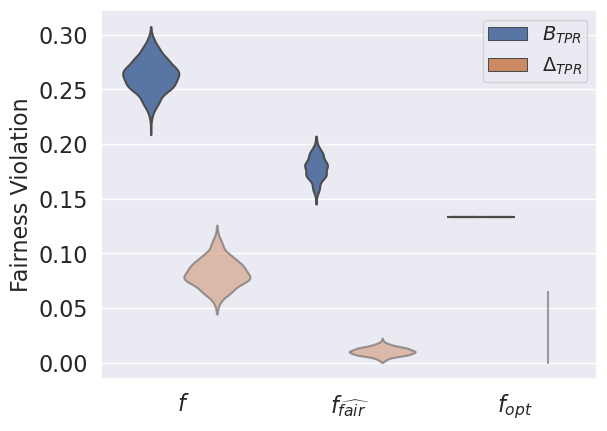

In [24]:
# Plotting theoretical tpr bounds and actual values
iter = K
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + th_b_tpr_fair + th_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
    hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, 'theo_b_tpr.pdf'), bbox_inches="tight")

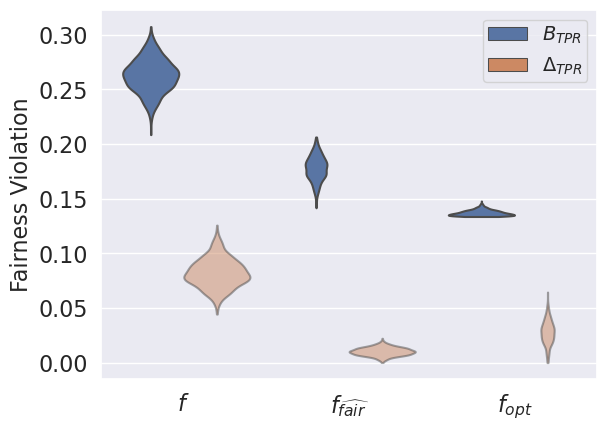

In [25]:
# Plotting actual tpr bounds and actual values
iter = K
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + ac_b_tpr_fair + ac_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
    hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, 'ac_b_tpr.pdf'),bbox_inches="tight")

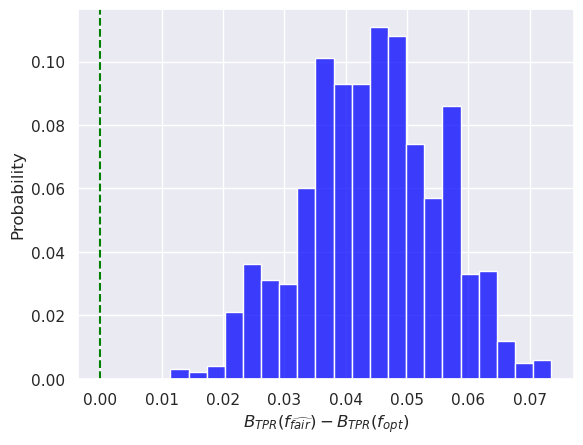

In [26]:
# Difference between theoretical tpr bounds
diff = np.array(th_b_tpr_fair) - np.array(th_b_tpr_opt)
sns.histplot(diff, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{TPR}(f_{\widehat{fair}}) - B_{TPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir, 'b_tpr_diff.pdf'),bbox_inches="tight")

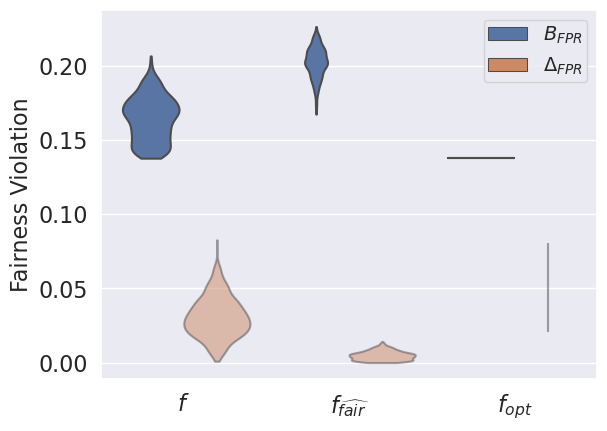

In [27]:
# Plotting theoretical fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + th_b_fpr_fair + th_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_fpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_fpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label',\
    hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, 'theo_b_fpr.pdf'),bbox_inches="tight")

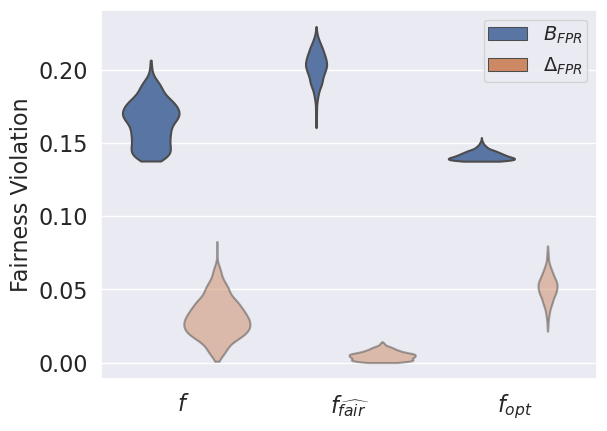

In [28]:
# Plotting actual fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + ac_b_fpr_fair + ac_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_fpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_fpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label',\
    hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir, 'ac_b_fpr.pdf'),bbox_inches="tight")

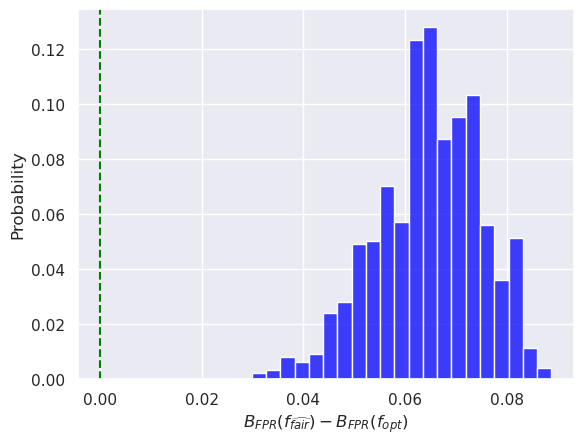

In [29]:
# Difference between theoretical fpr bounds
diff = np.array(th_b_fpr_fair) - np.array(th_b_fpr_opt)
sns.histplot(diff, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{FPR}(f_{\widehat{fair}}) - B_{FPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir, 'b_fpr_diff.pdf'),bbox_inches="tight")

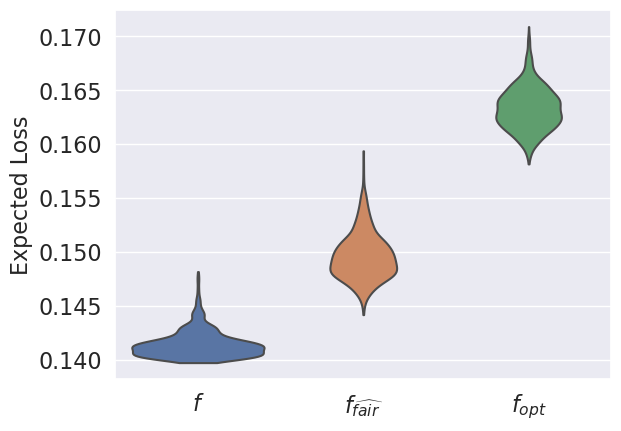

In [30]:
# Plotting expected loss
method =  [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
losses = o_loss + fair_loss + opt_loss
loss_df = pd.DataFrame(list(zip(losses, method)), columns =['Expected Loss', 'Classifier'])
sns.violinplot(data=loss_df, x = 'Classifier', y = 'Expected Loss', cut = 0, inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Expected Loss', fontsize=16)
plt.savefig(os.path.join(results_dir, 'loss.pdf'),bbox_inches="tight")